In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from unidecode import unidecode
import nltk
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import numpy as np 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from itertools import chain 
from nltk.tokenize import word_tokenize

In [2]:
df = pd.read_csv('All_Data.csv')

In [3]:
data = df[['comment_author', 'subreddit_name']].copy()


In [4]:
user_counts = data['comment_author'].value_counts()
common_users = user_counts[user_counts > 1].index
filtered_data = data[data['comment_author'].isin(common_users)]


In [5]:
G = nx.Graph()

for index, row in filtered_data.iterrows():
    G.add_edge(row['subreddit_name'], row['comment_author'])


In [6]:
common_users = set()
for node in G.nodes:
    neighbors = set(G.neighbors(node))
    if len(neighbors) > 1:
        common_users.update(neighbors)


In [7]:
len(common_users)

6263

Comment Count of user in each subreddit

In [8]:
# Iterate through unique subreddit names
for subreddit_name in data['subreddit_name'].unique():
    # Filter data for the current subreddit
    subreddit_data = data[data['subreddit_name'] == subreddit_name]

    # Find the number of comments each common user made in the current subreddit
    comment_counts = subreddit_data['comment_author'].value_counts()

    # Add a 'subreddit_comment_count' column for the current subreddit
    data.loc[data['subreddit_name'] == subreddit_name, 'subreddit_comment_count'] = data['comment_author'].map(comment_counts)


In [9]:
# Convert the 'subreddit_comment_count' column to integers and replace NaN values with 0
data['subreddit_comment_count'] = data['subreddit_comment_count'].fillna(0).astype(int)


Adding new column commented_subreddit to save all the subreddit names on which a user has commented.

In [10]:
# Group data by 'comment_author' and get unique subreddit names as a set
user_subreddit_sets = data.groupby('comment_author')['subreddit_name'].apply(set).reset_index()

# Merge the aggregated data back into the original DataFrame
data = data.merge(user_subreddit_sets, on='comment_author', suffixes=('', '_set'))

# Rename the new column to 'commented_subreddit'
data.rename(columns={'subreddit_name_set': 'commented_subreddit'}, inplace=True)


In [11]:
# Add a new column 'num_commented_subreddits' to store the count
data['num_commented_subreddits'] = data['commented_subreddit'].apply(lambda x: len(x))


In [12]:
data.head(10)

,comment_author,subreddit_name,subreddit_comment_count,commented_subreddit,num_commented_subreddits
0,Gseventeen,Fire,11,"{financialindependence, Fire}",2
1,Gseventeen,Fire,11,"{financialindependence, Fire}",2
2,Gseventeen,Fire,11,"{financialindependence, Fire}",2
3,Gseventeen,Fire,11,"{financialindependence, Fire}",2
4,Gseventeen,Fire,11,"{financialindependence, Fire}",2
5,Gseventeen,Fire,11,"{financialindependence, Fire}",2
6,Gseventeen,Fire,11,"{financialindependence, Fire}",2
7,Gseventeen,Fire,11,"{financialindependence, Fire}",2
8,Gseventeen,Fire,11,"{financialindependence, Fire}",2
9,Gseventeen,Fire,11,"{financialindependence, Fire}",2


Calculates total number of comments of a user in all the subreddits

In [13]:
# Calculate the total comment count for each user
user_total_comment_counts = data['comment_author'].value_counts().reset_index()
user_total_comment_counts.columns = ['comment_author', 'total_comment_count']

# Merge the total comment counts back into the original DataFrame
data = data.merge(user_total_comment_counts, on='comment_author', how='left')


In [14]:
data.head(10)

,comment_author,subreddit_name,subreddit_comment_count,commented_subreddit,num_commented_subreddits,total_comment_count
0,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
1,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
2,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
3,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
4,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
5,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
6,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
7,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
8,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
9,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15


In [15]:
data.to_csv("User_Network_Data.csv", index=False)

Function to create bar graph

In [16]:
# Function to create a bar graph for the top 50 users in a subreddit
def create_bar_graph(subreddit_name):
    subreddit_data = data[data['subreddit_name'] == subreddit_name]
    comment_counts = subreddit_data['comment_author'].value_counts()
    top_users = comment_counts.nlargest(25)

    plt.figure(figsize=(16, 10))
    plt.barh(top_users.index, top_users.values)
    plt.gca().invert_yaxis()
    plt.xlabel('Total Comments', fontsize=12)
    plt.ylabel('User', fontsize=12)
    plt.title(f'Top 25 Users in {subreddit_name}', fontsize=14)
    plt.xticks(fontsize=12)  # Increase font size of tick labels on the x-axis
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f'Top_25_Users_{subreddit_name}.png')

In [17]:
data['subreddit_name'].unique()



array(['Fire', 'financialindependence', 'FinancialPlanning', 'stocks'],
      dtype=object)

Creating bar grapgh to show top 50 users in subreddit 'Fire'

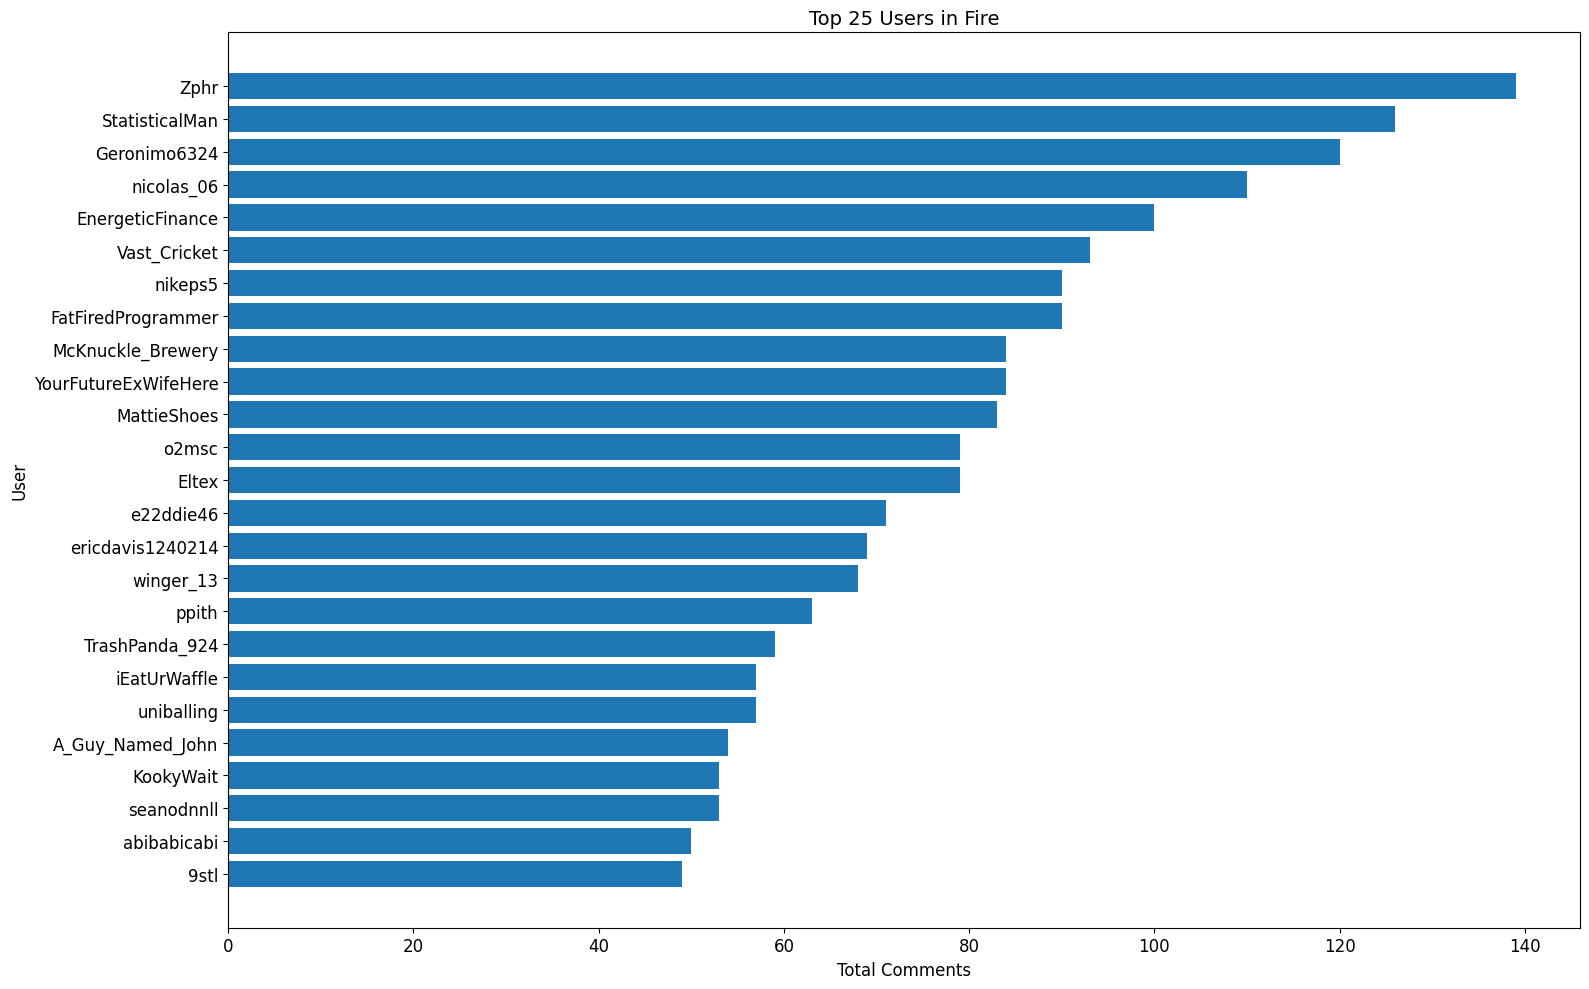

In [18]:
create_bar_graph('Fire')

Creating bar grapgh to show top 50 users in subreddit 'FinancialPlanning'

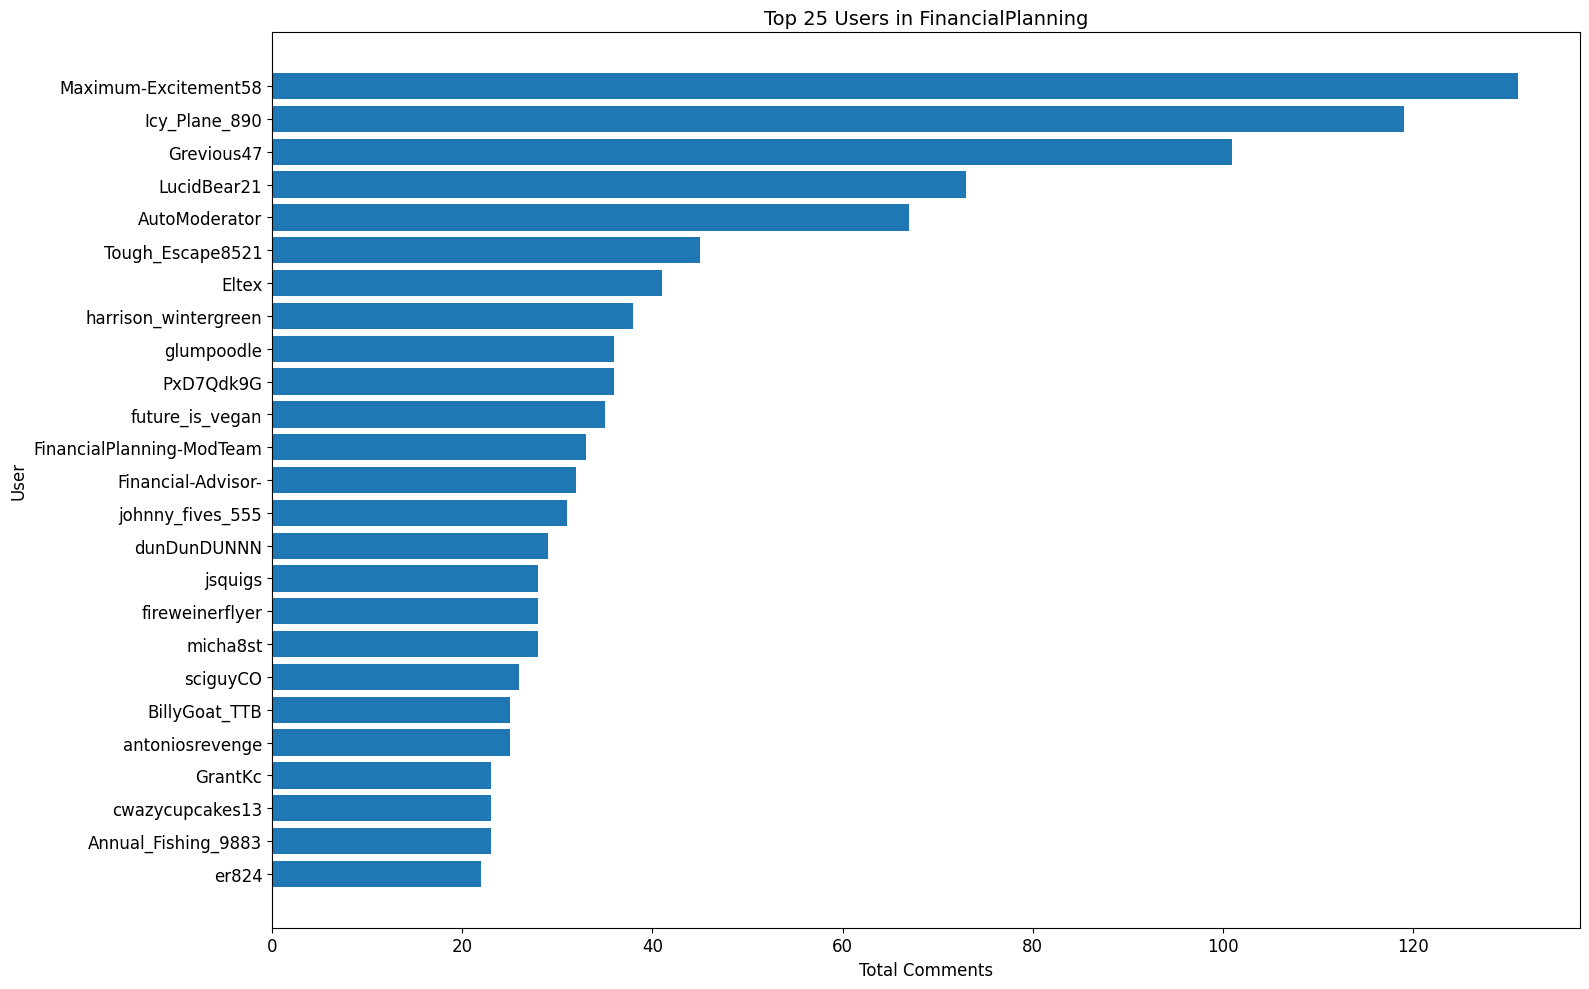

In [19]:
create_bar_graph('FinancialPlanning')

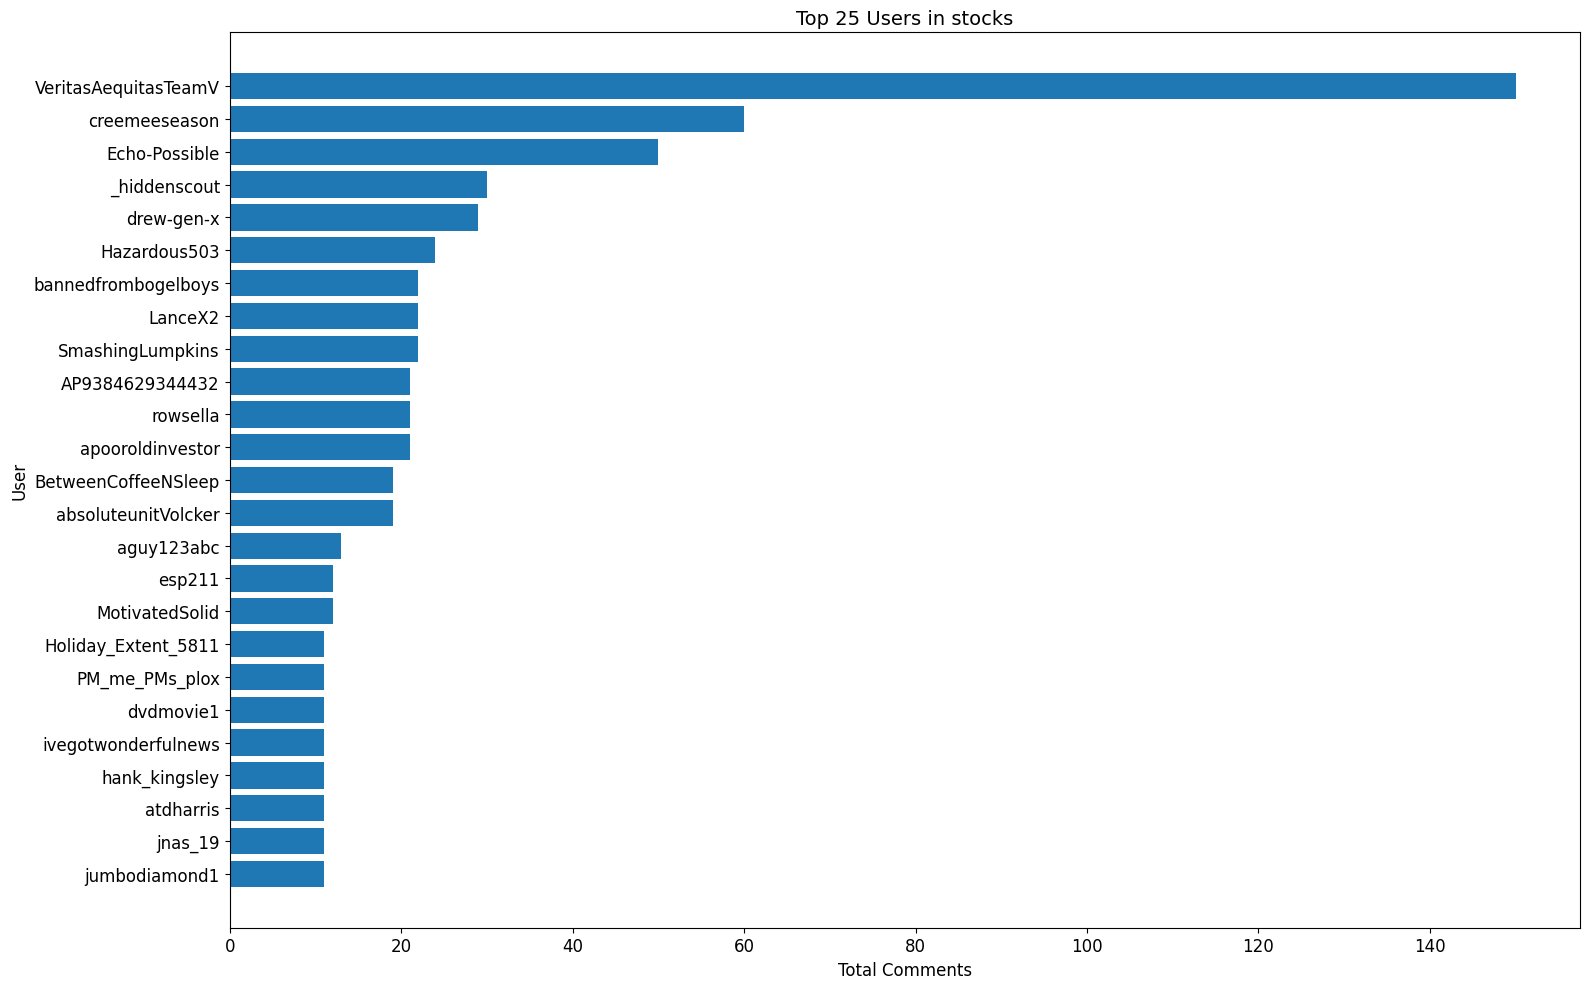

In [20]:
create_bar_graph('stocks')

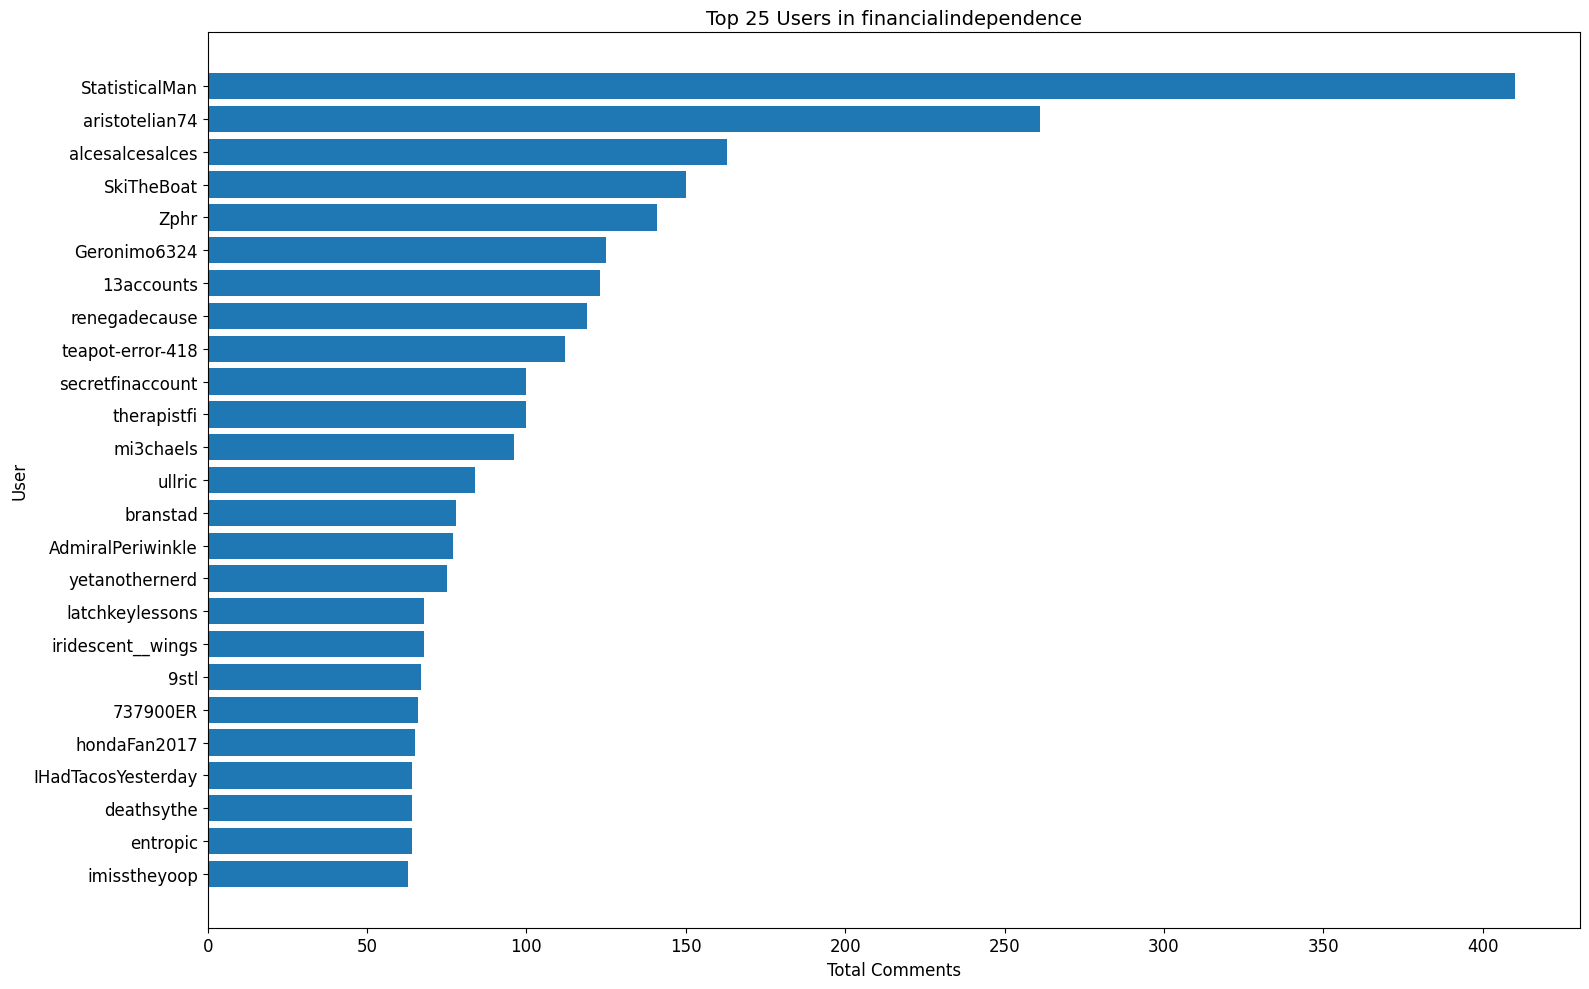

In [21]:
create_bar_graph('financialindependence')

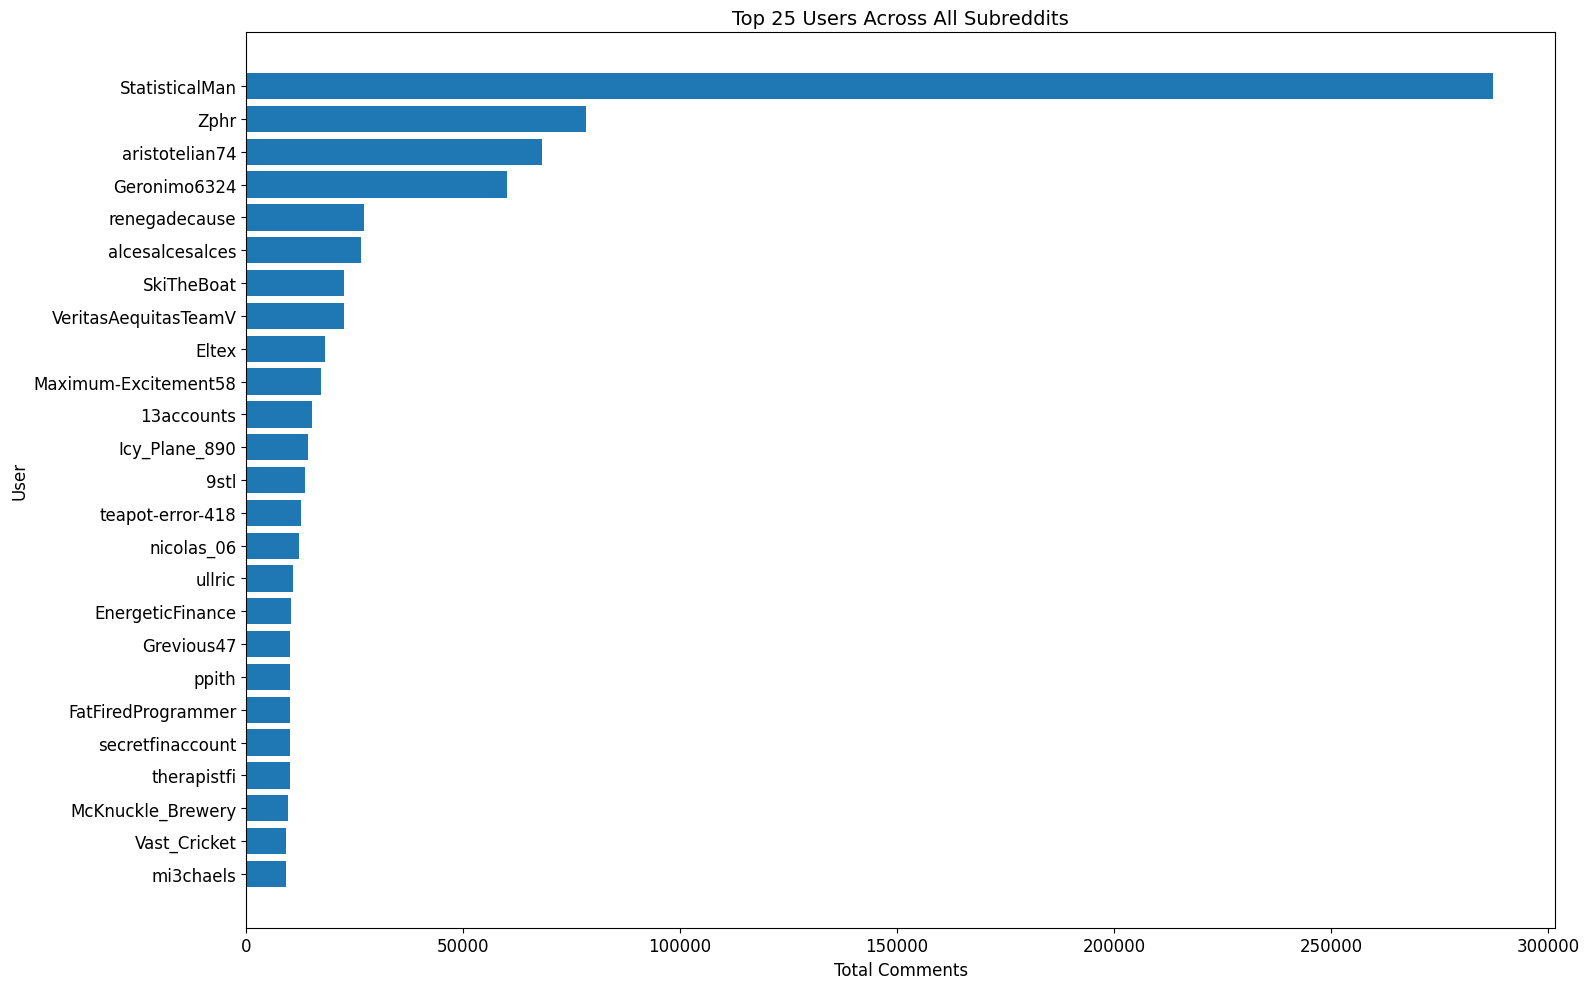

In [22]:
# Get the top 50 users who commented across all subreddits
top_users_all_subreddits = data[['comment_author', 'total_comment_count']].groupby('comment_author').sum().nlargest(25, 'total_comment_count')

# Create a bar graph for the top 50 users across all subreddits
plt.figure(figsize=(16, 10))
plt.barh(top_users_all_subreddits.index, top_users_all_subreddits['total_comment_count'])
plt.gca().invert_yaxis()
plt.xlabel('Total Comments', fontsize=12)
plt.ylabel('User', fontsize=12)
plt.title('Top 25 Users Across All Subreddits', fontsize=14)
plt.xticks(fontsize=12)  # Increase font size of tick labels on the x-axis
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Top_25_Users_All_Subreddits.png')

In [23]:
# Filter for users who have commented in at least three unique subreddits
common_users_in_3_subreddits = data[data['num_commented_subreddits'] >= 3]['comment_author'].unique()

# Display or save the list of common users
print("Common users who commented in at least three subreddits:")
print(common_users_in_3_subreddits)

Common users who commented in at least three subreddits:
['TrashPanda_924' 'cqzero' 'col02144' 'esp211' 'seanodnnll'
 'Legitimate_Stick9393' 'KookyWait' 'Eltex' 'EpicMediocrity00'
 'IceCreamforLunch' 'A_Guy_Named_John' 'MilitaryJAG' 'charleswj'
 'RocktownLeather' 'iranisculpable' 'Commercial_Seat_3704'
 'pf_burner_acct' 'Commercial_Rule_7823' 'Jellybeansxo' 'thisishard1001'
 'alexunderwater1' 'YoDo_GreenBackReaper' 'garoodah' 'glumpoodle'
 'OrganicFrost' 'National-Net-6831' 'p_ython' 'debbiewith2' 'lottadot'
 'igomhn3' 'Successful_Hold_9048' 'Nuclear_N' 'Scottfos72' 'saryiahan'
 'Noredditforwork' 'dissentmemo' 'srand42' 'Key_Preference_4594'
 'Varathien' 'quandlespoulesauront' 'Emily4571962' 'PhonyUsername'
 'Cake_And_Pi' '718cs' 'Iam_motivated_jay' 'BaBaBuyey' 'oduli81'
 'ExperienceOpposite62' 'tryingtogetfi' 'Atriev' 'Alternative-Plant-87'
 'Mid_AM' 'peter303_' 'NeoPrimitiveOasis' 'Rule_Of_72T' 'e22ddie46'
 'manimopo' 'zaclis7' 'Direct_Card3980' 'Familiar_Builder9007' 'moquito4u'
 'H

In [24]:
# Filter for users who have commented on more than three subreddits
users_with_more_than_3_subreddits = data[data['commented_subreddit'].str.len() > 3]

# Create a set to store unique combinations of users and their commented subreddits
unique_combinations = set()

# Iterate through the DataFrame to display unique combinations
for _, row in users_with_more_than_3_subreddits.iterrows():
    user = row['comment_author']
    subreddits = sorted(row['commented_subreddit'])  # Sort the subreddits for consistency
    unique_combinations.add((user, tuple(subreddits)))

# Display unique combinations
for combination in unique_combinations:
    user, subreddits = combination
    print(f'User: {user}')
    print(f'Commented Subreddits: {subreddits}')
    print()

User: TrashPanda_924
Commented Subreddits: ('FinancialPlanning', 'Fire', 'financialindependence', 'stocks')



In [25]:

# Filter for users who have commented on more than three subreddits
users_with_more_than_3_subreddits = data[data['commented_subreddit'].str.len() > 3]

# Create a list to store unique combinations of users, subreddits, and total comments
unique_combinations = []

# Create a set to track already added combinations
added_combinations = set()

# Iterate through the DataFrame to collect unique combinations
for _, row in users_with_more_than_3_subreddits.iterrows():
    user = row['comment_author']
    subreddits = tuple(sorted(row['commented_subreddit']))  # Convert set to a tuple for hashing
    total_comments = row['total_comment_count']
    
    # Represent the combination as a tuple
    combination = (user, subreddits, total_comments)

    # Check if the combination is unique
    if combination not in added_combinations:
        unique_combinations.append(combination)
        added_combinations.add(combination)

# Display unique combinations
for combination in unique_combinations:
    user, subreddits, total_comments = combination
    print(f'User: {user}')
    print(f'Commented Subreddits: {subreddits}')
    print(f'Total Comments: {total_comments}')
    print()




User: TrashPanda_924
Commented Subreddits: ('FinancialPlanning', 'Fire', 'financialindependence', 'stocks')
Total Comments: 66



In [26]:
common_users_in_4_subreddits =  data[data['num_commented_subreddits'] >= 4]['comment_author'].unique()
# Display or save the list of common users
print("Common users who commented in at least three subreddits:")
print(common_users_in_4_subreddits)

Common users who commented in at least three subreddits:
['TrashPanda_924']


In [27]:
# Filter the data based on 'num_commented_subreddits' greater than 1
filtered_data = data[data['num_commented_subreddits'] > 1]


In [28]:
filtered_data.head(10)

,comment_author,subreddit_name,subreddit_comment_count,commented_subreddit,num_commented_subreddits,total_comment_count
0,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
1,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
2,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
3,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
4,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
5,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
6,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
7,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
8,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15
9,Gseventeen,Fire,11,"{financialindependence, Fire}",2,15


In [29]:
# Create a graph
G = nx.Graph()

# Iterate through filtered data to add nodes and edges
for _, row in filtered_data.iterrows():
    user = row['comment_author']
    subreddits = row['commented_subreddit']
    
    # Add user node if not already present
    if not G.has_node(user):
        G.add_node(user, type='user')
    
    # Add subreddit nodes and edges
    for subreddit in subreddits:
        if not G.has_node(subreddit):
            G.add_node(subreddit, type='subreddit')
        G.add_edge(user, subreddit)

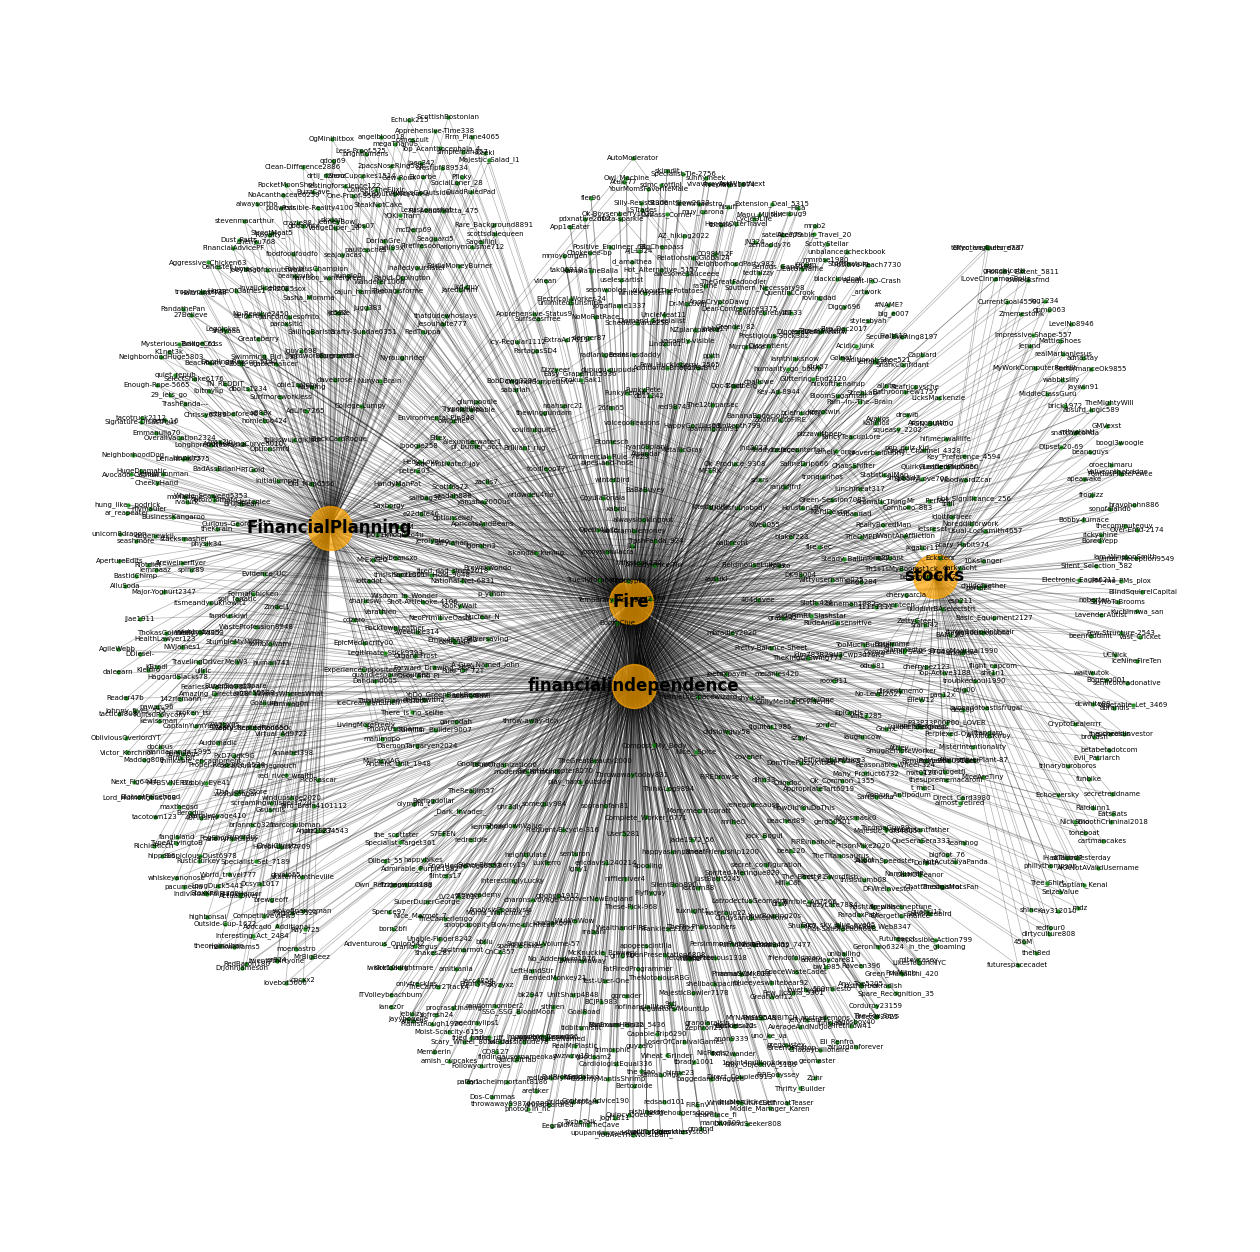

In [30]:

# Create a layout for visualization
pos = nx.spring_layout(G)

# Decrease the size of user nodes and increase the size of the entire graph
user_node_size = 5
subreddit_node_size = 1000
plt.figure(figsize=(16, 16))

# Draw nodes
user_nodes = {n for n, d in G.nodes(data=True) if d['type'] == 'user'}
subreddit_nodes = set(G) - user_nodes


# Draw labels (optional)
nx.draw_networkx_nodes(G, pos, nodelist=subreddit_nodes, node_color='orange', node_size=subreddit_node_size, node_shape='o', alpha=0.7)
labels = {node: node for node in user_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=5)
subreddit_labels = {node: node for node in subreddit_nodes}
nx.draw_networkx_labels(G, pos, labels=subreddit_labels, font_size=12, font_weight='bold')


nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='green', node_size=user_node_size, node_shape='o', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)

# Set axis off for cleaner visualization
plt.axis('off')

# Show the graph
plt.show()

In [31]:
# Create a graph from your data
G = nx.from_pandas_edgelist(data, source='comment_author', target='subreddit_name')

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Add degree centrality values to the original DataFrame
data['degree_centrality'] = data['comment_author'].map(degree_centrality)

In [32]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Add betweenness centrality values to the original DataFrame
data['betweenness_centrality'] = data['comment_author'].map(betweenness_centrality)


In [33]:
# Create a DataFrame to store user names, degree centrality, and betweenness centrality
unique_users = data['comment_author'].unique()

centrality_data = pd.DataFrame({
    'comment_author': unique_users,
    'degree_centrality': [degree_centrality.get(user, 0) for user in unique_users],
    'betweenness_centrality': [betweenness_centrality.get(user, 0) for user in unique_users]
})

In [36]:
unique_users

array(['Gseventeen', 'play_hard_outside', 'Blackrock_38', ...,
       'OtherLeader5437', 'nmnnmmnnnmmm', 'croble1'], dtype=object)

In [37]:
# Find the user with the maximum degree centrality in the DataFrame
max_degree_user = data.loc[data['degree_centrality'].idxmax()]

print("User with maximum degree centrality:", max_degree_user['comment_author'])
print("Degree centrality:", max_degree_user['degree_centrality'])

User with maximum degree centrality: TrashPanda_924
Degree centrality: 0.000262639527248851


In [41]:
# Sort the DataFrame by 'degree_centrality' in descending order
sorted_centrality_data = data.sort_values(by='degree_centrality', ascending=False)

# Deduplicate the data to keep unique users
unique_users = sorted_centrality_data.drop_duplicates(subset='comment_author')

# Get the top 1000 unique users with the highest degree centrality
top_1000_unique_users = unique_users.head(1000)

# Display the top 1000 unique users with the highest degree centrality
print("Top 1000 unique users with the highest degree centrality:")
print(top_1000_unique_users[['comment_author', 'degree_centrality']])


Top 1000 unique users with the highest degree centrality:
             comment_author  degree_centrality
152          TrashPanda_924           0.000263
14056  Alternative-Plant-87           0.000197
1322             seanodnnll           0.000197
13645                Atriev           0.000197
22822                fp011k           0.000197
...                     ...                ...
6538             gregaustex           0.000131
6545              canescult           0.000131
727          FujitsuPolycom           0.000131
3807             10Kslanger           0.000131
3791     semicoloradonative           0.000131

[1000 rows x 2 columns]


In [42]:
# Sort the top 1000 users by 'total_comment_count' in descending order
sorted_top_1000_comment_users = top_1000_unique_users.sort_values(by='total_comment_count', ascending=False)

# Get the top 25 users with the highest total comment count from the top 1000 users
top_25_comment_users = sorted_top_1000_comment_users.head(25)

# Display the top 20 users with the highest total comment count from the top 1000 users
print("Top 25 users with the highest total comment count from the top 1000 users according to centrality:")
print(top_25_comment_users[['comment_author', 'total_comment_count','num_commented_subreddits']])


Top 25 users with the highest total comment count from the top 1000 users according to centrality:
             comment_author  total_comment_count  num_commented_subreddits
2391         StatisticalMan                  536                         2
6476           Geronimo6324                  245                         2
1847                  Eltex                  135                         3
17398                  9stl                  116                         2
26104                ullric                  104                         2
985       McKnuckle_Brewery                   98                         2
616            Vast_Cricket                   96                         2
14789             e22ddie46                   82                         3
3630       ericdavis1240214                   78                         2
26423         AutoModerator                   75                         2
1638              KookyWait                   74                         3
2

In [43]:
# Explode the 'commented_subreddit' column to create user-subreddit pairs
exploded_df = top_25_comment_users.explode('commented_subreddit')

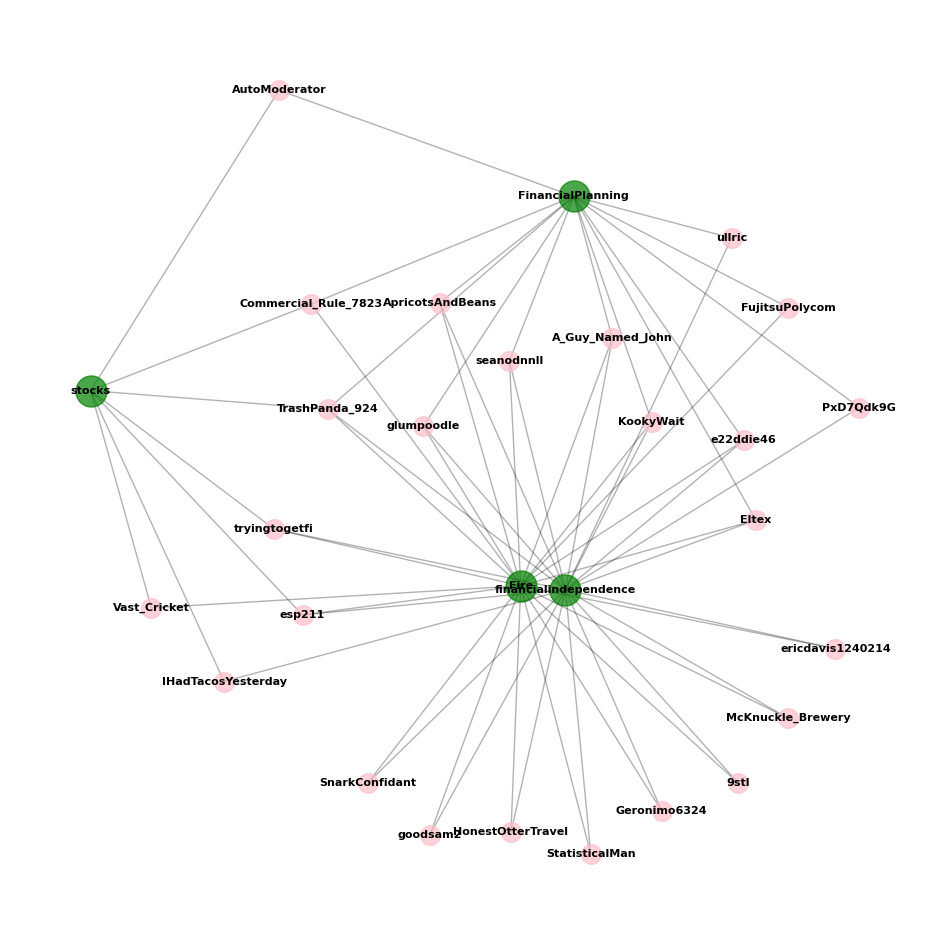

In [46]:
# Create a graph
G = nx.Graph()

# Add nodes for users and subreddits
users = exploded_df['comment_author'].unique()
subreddits = exploded_df['commented_subreddit'].unique()

G.add_nodes_from(users, type='user')
G.add_nodes_from(subreddits, type='subreddit')

# Create edges between users and their commented subreddits
user_subreddit_pairs = exploded_df[['comment_author', 'commented_subreddit']].values
G.add_edges_from(user_subreddit_pairs)

# Create a layout using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

# Visualize the graph
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=users, node_color='pink', node_size=200, node_shape='o', alpha=0.7)
nx.draw_networkx_nodes(G, pos, nodelist=subreddits, node_color='green', node_size=500, node_shape='o', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3)

# Add labels for subreddits
subreddit_labels = {node: node for node in subreddits}
nx.draw_networkx_labels(G, pos, labels=subreddit_labels, font_size=8, font_weight='bold')

# Add labels for usernames
user_labels = {node: node for node in users}
nx.draw_networkx_labels(G, pos, labels=user_labels, font_size=8, font_weight='bold')

# Set axis off for cleaner visualization
plt.axis('off')

# Show the graph
plt.show()


In [47]:
# Extract the usernames of the top 25 users
top_25_usernames = top_25_comment_users['comment_author']

# Filter the original dataset to get comments for the top 25 users
comments_for_top_25_users = df[df['comment_author'].isin(top_25_usernames)]


In [48]:
comments_for_top_25_users

,subreddit_name,post_title,post_author,comment,comment_author
13,Fire,FIRE accomplished!,Variouswires9115,Congrats!!! Wishing you the best in the next p...,TrashPanda_924
40,Fire,What’s a lucrative midlife career change? Seek...,tryin-my-best-,Get retrained.,Vast_Cricket
43,Fire,What’s a lucrative midlife career change? Seek...,tryin-my-best-,It's always interesting to me when people reco...,FujitsuPolycom
46,Fire,What’s a lucrative midlife career change? Seek...,tryin-my-best-,Open pit mining. Hire anyone. 100k start with ...,FujitsuPolycom
69,Fire,"26 years old and in a good spot, what would yo...",dqrules11,You don't live off *only* interest OR let the ...,McKnuckle_Brewery
...,...,...,...,...,...
48851,financialindependence,Can I FIRE in 10 years? What's my next play?,Accurate_Sense_8029,The rental is a math problem in 10 years. No ...,Eltex
48862,financialindependence,How do I level up my finances?,Fresh-Ad9946,[backdoor roth](https://www.whitecoatinvestor....,Eltex
48865,financialindependence,How do I level up my finances?,Fresh-Ad9946,Spending not income is likely the issue. Less...,StatisticalMan
48880,financialindependence,How do I level up my finances?,Fresh-Ad9946,"Yes, he did:\n* $200K salary \n* working 80hrs...",Eltex


In [49]:
comments_for_top_25_users.to_csv("Top25_Users_Data.csv", index =False)

# Influencers' Data Exploration

In [51]:
df = pd.read_json("Reddit_Influencers_Cleaned_data.json", lines=True)

# Sentimental Analysis

In [52]:
# VADER 
analyzer = SentimentIntensityAnalyzer()

# Create a function to calculate sentiment scores
def get_sentiment_scores(tokens):
    # Combine the lemmatized tokens back into a text
    text = ' '.join(tokens)
    
    # Calculate sentiment scores
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score >= 0.05:
        sentiment_label = 'Positive'
    elif compound_score <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return compound_score, sentiment_label

# Calculate sentiment scores for each row and store them in new columns
df[['vader_compound_score', 'vader_sentiment']] = df['lemmatized_tokens'].apply(get_sentiment_scores).apply(pd.Series)


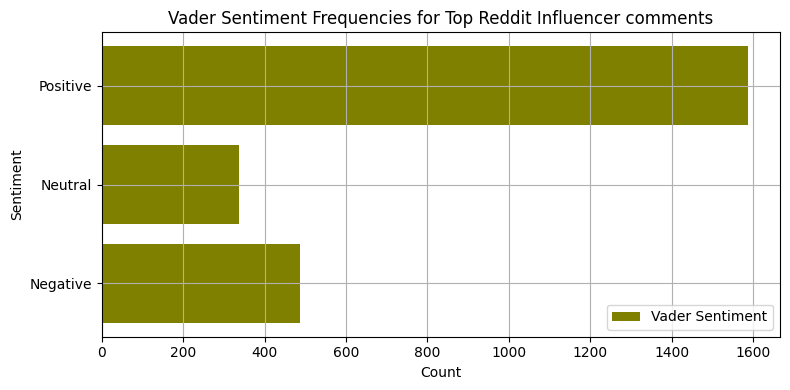

In [53]:
vader_sentiment_counts = df.groupby('vader_sentiment').size()

# Create a single graph for sentiment and Vader sentiment vs frequency
plt.figure(figsize=(8, 4))

# Plot Vader sentiment counts
plt.barh(vader_sentiment_counts.index, vader_sentiment_counts.values, color='olive', label='Vader Sentiment')

plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title('Vader Sentiment Frequencies for Top Reddit Influencer comments')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

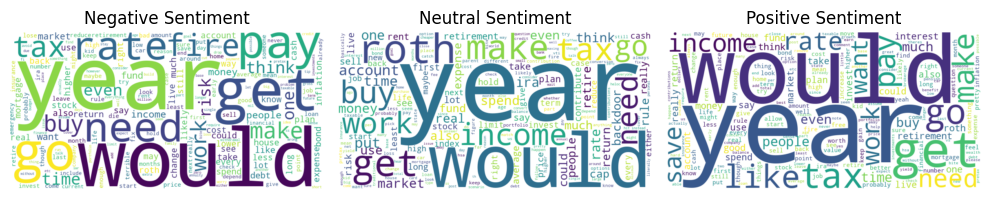

In [54]:
# Group data by sentiment and merge tokens
grouped = df.groupby('vader_sentiment')['lemmatized_tokens'].apply(lambda x: [token for sublist in x for token in sublist])

# Count word frequencies in each sentiment group
word_counts = {sentiment: Counter(tokens) for sentiment, tokens in grouped.items()}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Create word clouds for each sentiment group and display in subplots
for i, (sentiment, counts) in enumerate(word_counts.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    axes[i].axis('off')

# Adjust layout spacing
plt.tight_layout()
plt.show()

In [55]:
# Define a list of words to remove
remove_words = ['would', 'get', 'year', 'go', 'sense', 'sure', 'like', 'seem', 'sound', 'thank']

# Apply a lambda function to remove specified words
df['cleaned_lemmatized_tokens'] = df['lemmatized_tokens'].apply(lambda tokens: [word for word in tokens if word not in remove_words])


# Topic modelling

In [56]:
# Function to create n-grams with space-separated tokens
def create_space_separated_bigrams(text):
    tokens = word_tokenize(text)
    bigrams = list(ngrams(tokens, 2))
    return [' '.join(bigram) for bigram in bigrams]

# Assuming df1 has a column named 'lemmatized_filtered_tokens'
df['space_separated_bigrams'] = df['cleaned_lemmatized_tokens'].apply(lambda tokens: create_space_separated_bigrams(' '.join(tokens)))

BOW method

In [57]:
dictionary = corpora.Dictionary(df['space_separated_bigrams'])

# Create a corpus (bag of words representation) from the unigrams
corpus = [dictionary.doc2bow(bigram) for bigram in df['space_separated_bigrams']]

# Build the LDA model
lda_model_bow = LdaModel(corpus, num_topics= 4, id2word=dictionary, passes=15)

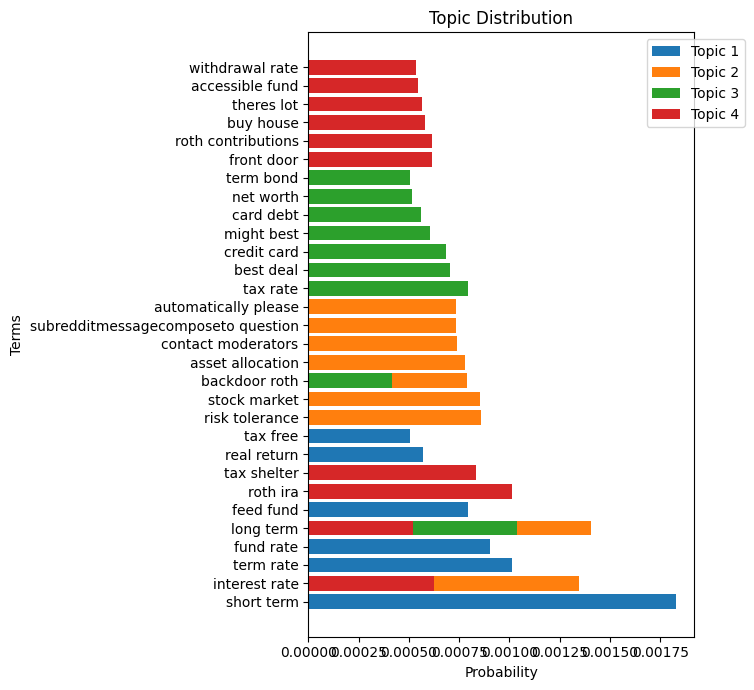

In [58]:
# Get the topic-term matrix
topic_terms = lda_model_bow.get_topics()

# Normalize the topic-term matrix
topic_terms /= topic_terms.sum(axis=1)[:, np.newaxis]

# Get the top terms for each topic
num_top_terms = 10  # You can adjust the number of top terms
top_terms_per_topic = [lda_model_bow.show_topic(topic_id, topn=num_top_terms) for topic_id in range(4)]

# Adjust figure size
plt.figure(figsize=(8,7))

# Create a bar plot for each topic
for topic_id, top_terms in enumerate(top_terms_per_topic):
    terms, probabilities = zip(*top_terms)
    plt.barh(terms, probabilities, label=f"Topic {topic_id + 1}")

plt.xlabel('Probability')
plt.ylabel('Terms')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('Topic Distribution')
plt.tight_layout()
plt.show()


In [59]:
for topic_id, top_terms in enumerate(top_terms_per_topic):
    terms, _ = zip(*top_terms)  # Ignore the probabilities
    print(f"Topic {topic_id + 1} :\n {terms}")

Topic 1 :
 ('short term', 'interest rate', 'term rate', 'fund rate', 'long term', 'feed fund', 'roth ira', 'tax shelter', 'real return', 'tax free')
Topic 2 :
 ('long term', 'interest rate', 'roth ira', 'risk tolerance', 'stock market', 'backdoor roth', 'asset allocation', 'contact moderators', 'subredditmessagecomposeto question', 'automatically please')
Topic 3 :
 ('long term', 'roth ira', 'tax rate', 'best deal', 'credit card', 'might best', 'card debt', 'net worth', 'term bond', 'backdoor roth')
Topic 4 :
 ('roth ira', 'tax shelter', 'interest rate', 'front door', 'roth contributions', 'buy house', 'theres lot', 'accessible fund', 'withdrawal rate', 'long term')


In [60]:

# Set of bigrams to identify
bigrams_to_identify_Topic1 = {'credit card', 'interest rate', 'card debt'}

# Function to check if a comment contains any of the specified bigrams
def contains_bigrams(comment):
    for bigram in bigrams_to_identify_Topic1:
        if bigram in comment:
            return True
    return False

# Apply the contains_bigrams function to your DataFrame to create a new column
df['Contains_Bigrams_Topic1'] = df['space_separated_bigrams'].apply(contains_bigrams)

# Filter the DataFrame to get comments that contain the specified bigrams
comments_with_bigrams_topic1 = df[df['Contains_Bigrams_Topic1']]

# Count the number of rows where 'Contains_Bigrams' is True
num_comments_with_bigrams_topic1 = len(comments_with_bigrams_topic1)

# Print the number of comments that contain the specified bigrams
print(f"Number of comments that contain the specified bigrams: {num_comments_with_bigrams_topic1}")



Number of comments that contain the specified bigrams: 82


In [61]:

# Find the 5 most positive comments
top_5_positive = comments_with_bigrams_topic1.nlargest(5, 'vader_compound_score')

# Find the 5 most negative comments
top_5_negative = comments_with_bigrams_topic1.nsmallest(5, 'vader_compound_score')

# Display the results
print("5 Most Positive Comments:")
print(top_5_positive[['comment', 'vader_compound_score']])  

print("\n5 Most Negative Comments:")
print(top_5_negative[['comment', 'vader_compound_score']])  


5 Most Positive Comments:
                                                comment  vader_compound_score
2099  Rates are set by supply and demand. Yes the tr...                0.9911
1467  >Depending on the source, I've seen people rep...                0.9868
2182  >The financial institution holding your 401(k)...                0.9844
881   I agree with this take. But upon hearing that ...                0.9828
725   >I’m trying to figure out the best place to pa...                0.9803

5 Most Negative Comments:
                                                comment  vader_compound_score
303   Credit card debt has to go.  Credit card debt ...               -0.8768
1112  Your problem is not your debts, it's your budg...               -0.8268
2343  I changed.  I am glad my wife didn't listen to...               -0.7140
2332  He is still in CC debt and has been for eight ...               -0.6118
1740  Did you pay by credit card?    \nYou can do a ...               -0.5994


In [62]:
comments_with_bigrams_topic1.to_csv("Topic1_Comments.csv", index = False)

In [63]:
# Set of bigrams to identify
bigrams_to_identify_Topic2 = {'roth ira', 'pay house', 'long term'}

# Function to check if a comment contains any of the specified bigrams
def contains_bigrams(comment):
    for bigram in bigrams_to_identify_Topic2:
        if bigram in comment:
            return True
    return False

# Apply the contains_bigrams function to your DataFrame to create a new column
df['Contains_Bigrams_Topic2'] = df['space_separated_bigrams'].apply(contains_bigrams)

# Filter the DataFrame to get comments that contain the specified bigrams
comments_with_bigrams_topic2 = df[df['Contains_Bigrams_Topic2']]

# Count the number of rows where 'Contains_Bigrams' is True
num_comments_with_bigrams_topic2 = len(comments_with_bigrams_topic2)

# Print the number of comments that contain the specified bigrams
print(f"Number of comments that contain the specified bigrams: {num_comments_with_bigrams_topic2}")



Number of comments that contain the specified bigrams: 155


In [64]:

# Find the 5 most positive comments
top_5_positive = comments_with_bigrams_topic2.nlargest(5, 'vader_compound_score')

# Find the 5 most negative comments
top_5_negative = comments_with_bigrams_topic2.nsmallest(5, 'vader_compound_score')

# Display the results
print("5 Most Positive Comments:")
print(top_5_positive[['comment', 'vader_compound_score']])  

print("\n5 Most Negative Comments:")
print(top_5_negative[['comment', 'vader_compound_score']])  


5 Most Positive Comments:
                                                comment  vader_compound_score
2099  Rates are set by supply and demand. Yes the tr...                0.9911
2066  Truly, you need a retirement plan. Not a finan...                0.9893
1906  HSA is the perfect investment vehicle (make su...                0.9887
1467  >Depending on the source, I've seen people rep...                0.9868
725   >I’m trying to figure out the best place to pa...                0.9803

5 Most Negative Comments:
                                                comment  vader_compound_score
1227  **No way pulling out from the IRA.**\nI wouldn...               -0.8894
1786  Yeah it really is just a quirk of the taxcode....               -0.7717
323   Long term treasury yields are not negative and...               -0.7650
2332  He is still in CC debt and has been for eight ...               -0.6118
1104  DON’T get whole life insurance. You might not ...               -0.5859


In [65]:
comments_with_bigrams_topic2.to_csv("Topic2_Comments.csv", index = False)

In [66]:
# Set of bigrams to identify
bigrams_to_identify_Topic3 = {'real return', 'risk tolerance', 'stock market'}

# Function to check if a comment contains any of the specified bigrams
def contains_bigrams(comment):
    for bigram in bigrams_to_identify_Topic1:
        if bigram in comment:
            return True
    return False

# Apply the contains_bigrams function to your DataFrame to create a new column
df['Contains_Bigrams_Topic3'] = df['space_separated_bigrams'].apply(contains_bigrams)

# Filter the DataFrame to get comments that contain the specified bigrams
comments_with_bigrams_topic3 = df[df['Contains_Bigrams_Topic3']]

# Count the number of rows where 'Contains_Bigrams' is True
num_comments_with_bigrams_topic3 = len(comments_with_bigrams_topic3)

# Print the number of comments that contain the specified bigrams
print(f"Number of comments that contain the specified bigrams: {num_comments_with_bigrams_topic3}")



Number of comments that contain the specified bigrams: 82


In [67]:

# Find the 5 most positive comments
top_5_positive = comments_with_bigrams_topic3.nlargest(5, 'vader_compound_score')

# Find the 5 most negative comments
top_5_negative = comments_with_bigrams_topic3.nsmallest(5, 'vader_compound_score')

# Display the results
print("5 Most Positive Comments:")
print(top_5_positive[['comment', 'vader_compound_score']])  

print("\n5 Most Negative Comments:")
print(top_5_negative[['comment', 'vader_compound_score']])  

5 Most Positive Comments:
                                                comment  vader_compound_score
2099  Rates are set by supply and demand. Yes the tr...                0.9911
1467  >Depending on the source, I've seen people rep...                0.9868
2182  >The financial institution holding your 401(k)...                0.9844
881   I agree with this take. But upon hearing that ...                0.9828
725   >I’m trying to figure out the best place to pa...                0.9803

5 Most Negative Comments:
                                                comment  vader_compound_score
303   Credit card debt has to go.  Credit card debt ...               -0.8768
1112  Your problem is not your debts, it's your budg...               -0.8268
2343  I changed.  I am glad my wife didn't listen to...               -0.7140
2332  He is still in CC debt and has been for eight ...               -0.6118
1740  Did you pay by credit card?    \nYou can do a ...               -0.5994


In [68]:
comments_with_bigrams_topic3.to_csv("Topic3_Comments.csv", index = False)